# Signal Detection and Classification in Shared Spectrum with LSTM-S
I/Q pair as input

In [ ]:
IQ_PAIR = 512
INPUT_SIZE = 2
CLASSES = ['wifi', 'lte', 'nr5g']
NUM_CLASSES = len(CLASSES)

## 1. Import Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
!pip install torchinfo
from torchinfo import summary

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [ ]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


## 2. Dataset
Generated data can be also downloaded from [my Google Drive](https://drive.google.com/file/d/1sjkl9PG-CbqHMXUwUNx1jfrjSu0x9B2F/view?usp=sharing).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)
! unzip -q "/content/gdrive/MyDrive/Colab Notebooks/CENG501 - Spring2021/Project/data_snr20.zip"

Mounted at /content/gdrive


### 2.1 WiFi Data

In [ ]:
wifi_files = glob.glob("/content/wifi/*.txt")
wifi_df = pd.DataFrame()

for f in sorted(wifi_files):
    csv = pd.read_csv(f, converters={'I+Qi': lambda s: np.complex(s.replace('i', 'j'))})
    wifi_df = wifi_df.append(csv)

### 2.2 LTE Data

In [ ]:
lte_files = glob.glob("/content/lte/*.txt")
lte_df = pd.DataFrame()

for f in sorted(lte_files):
    csv = pd.read_csv(f, converters={'I+Qi': lambda s: np.complex(s.replace('i', 'j'))})
    lte_df = lte_df.append(csv)

### 2.3 5G-NR Data

In [ ]:
nr5g_files = glob.glob("/content/nr5g/*.txt")
nr5g_df = pd.DataFrame()

for f in sorted(nr5g_files):
    csv = pd.read_csv(f, converters={'I+Qi': lambda s: np.complex(s.replace('i', 'j'))})
    nr5g_df = nr5g_df.append(csv)

### 2.4 Visualization 

In [ ]:
n = 5000
sample = 512
begin, end = n, n + sample

#### 2.4.1 Time-Domain

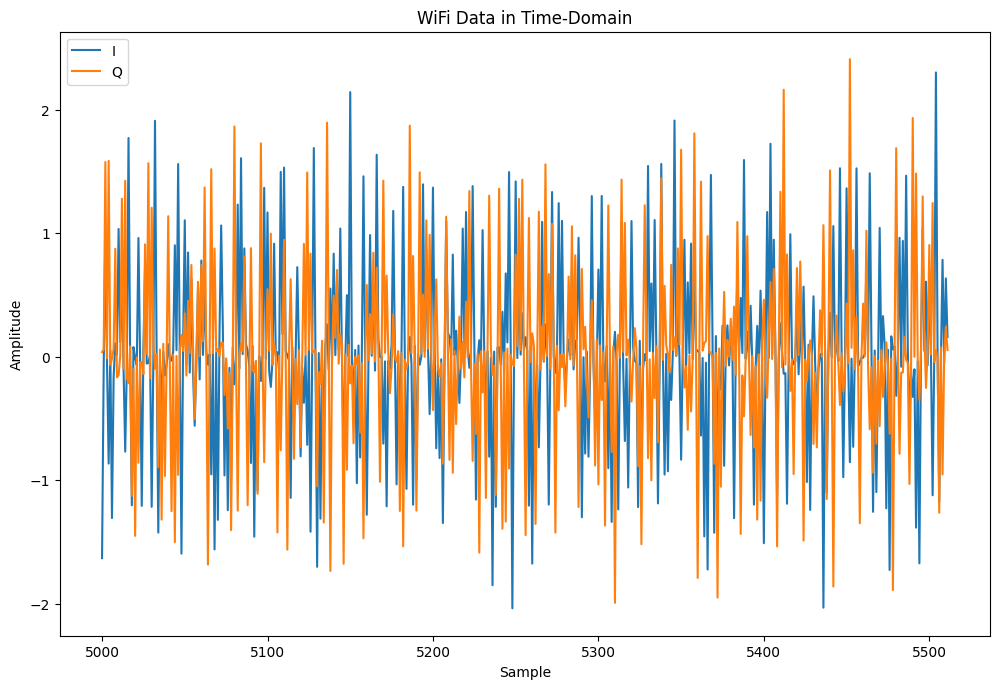

In [ ]:
plt.plot(wifi_df.apply(np.real).iloc[begin:end], label='I')
plt.plot(wifi_df.apply(np.imag).iloc[begin:end], label='Q')
plt.title('WiFi Data in Time-Domain')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

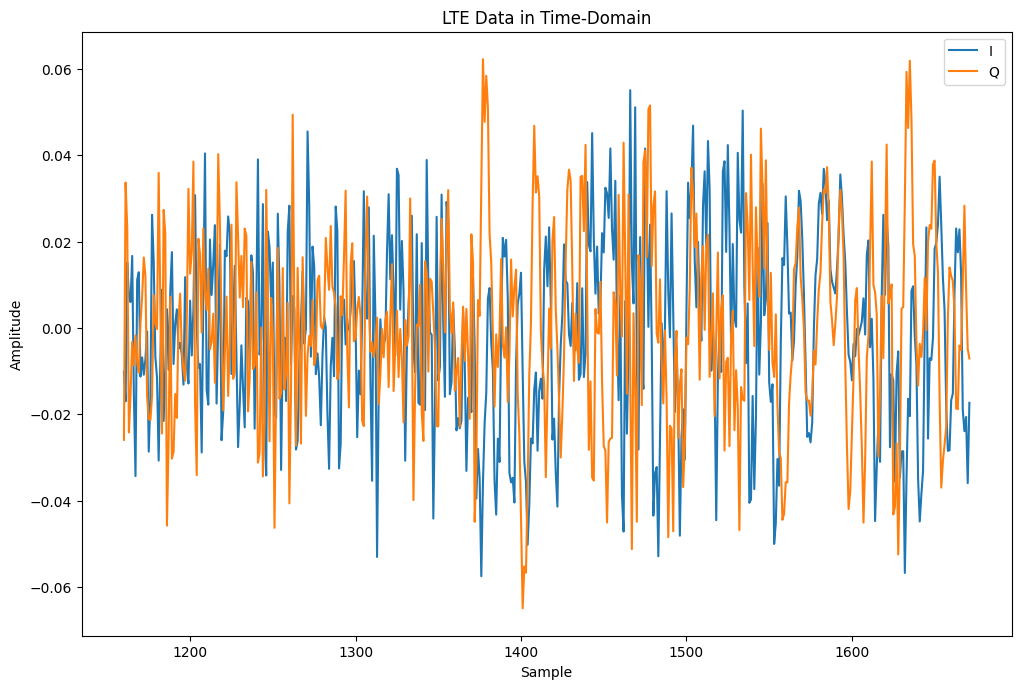

In [ ]:
plt.plot(lte_df.apply(np.real).iloc[begin:end], label='I')
plt.plot(lte_df.apply(np.imag).iloc[begin:end], label='Q')
plt.title('LTE Data in Time-Domain')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

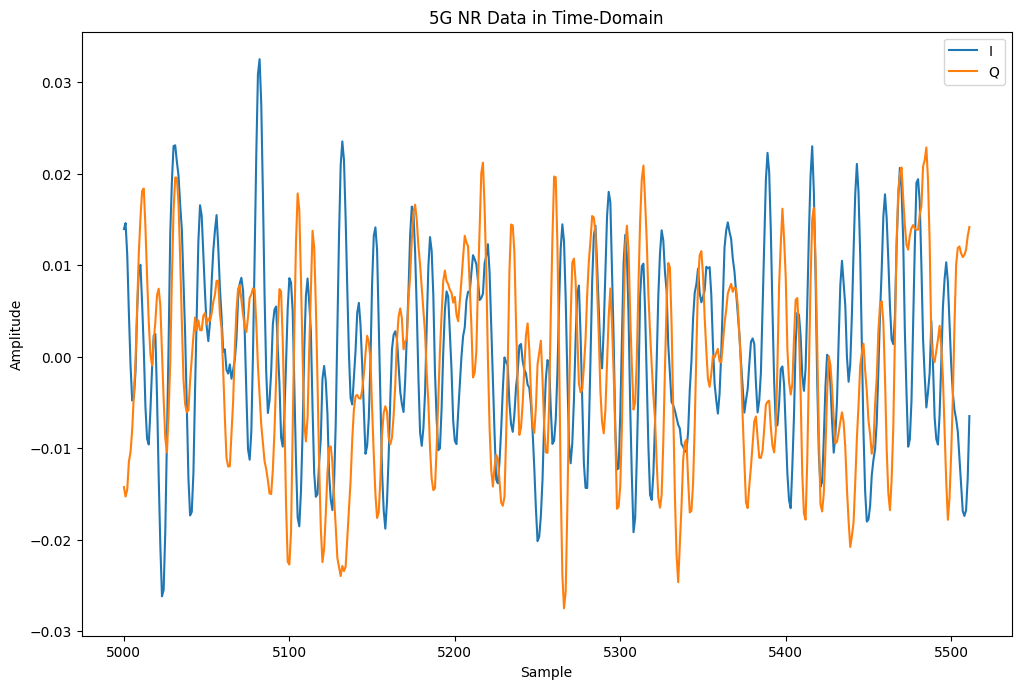

In [ ]:
plt.plot(nr5g_df.apply(np.real).iloc[begin:end], label='I')
plt.plot(nr5g_df.apply(np.imag).iloc[begin:end], label='Q')
plt.title('5G NR Data in Time-Domain')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

#### 2.4.2 Constellation Scheme

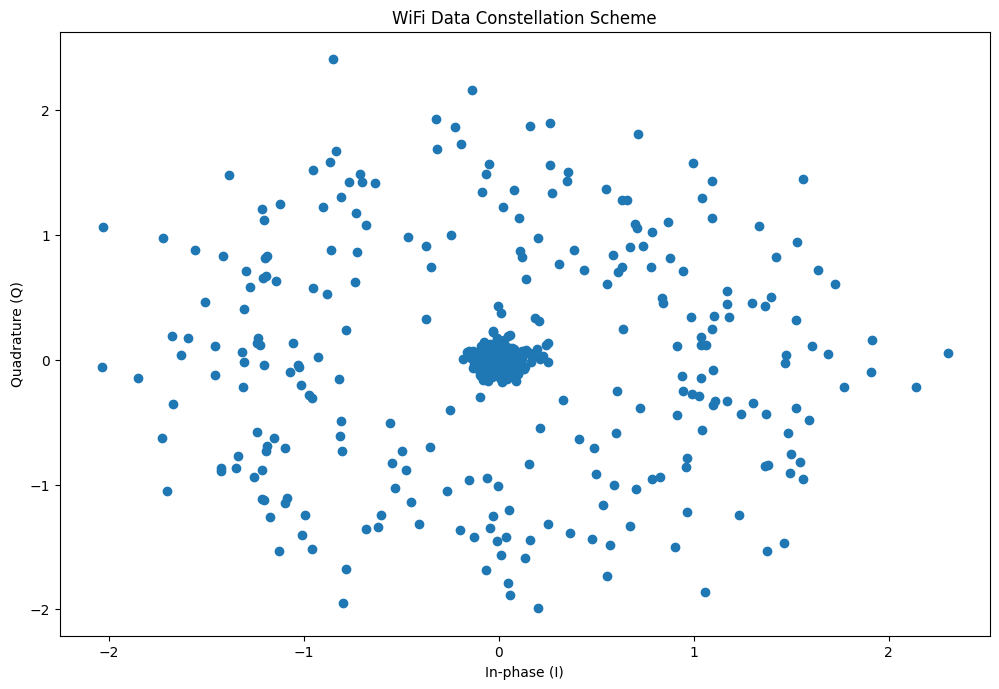

In [ ]:
plt.scatter(wifi_df.apply(np.real).iloc[begin:end], wifi_df.apply(np.imag).iloc[begin:end])
plt.title('WiFi Data Constellation Scheme')
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.show()

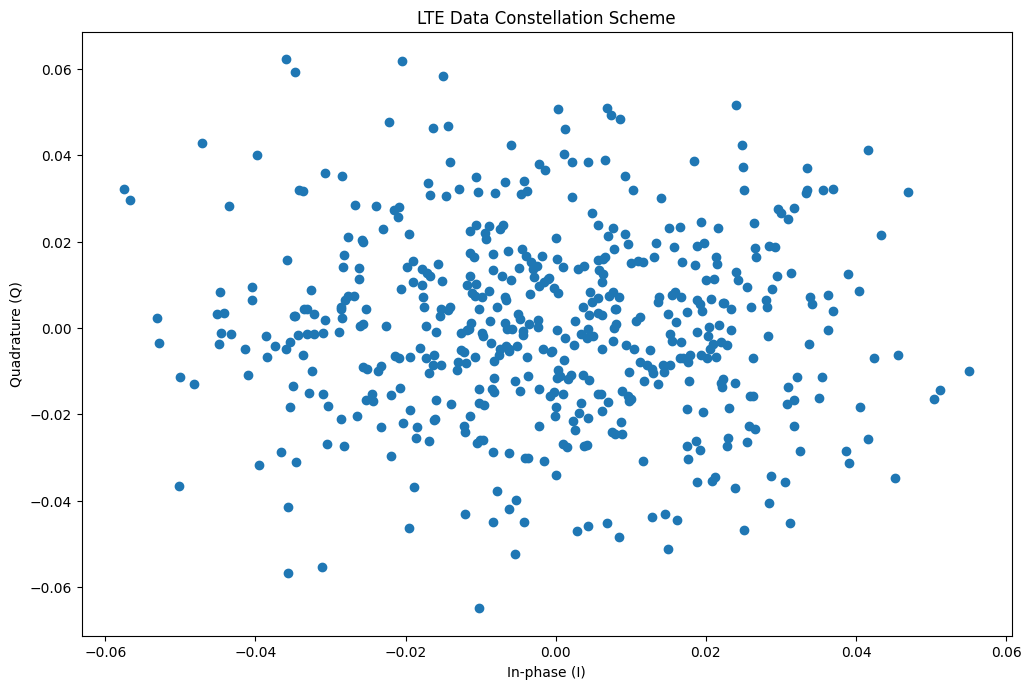

In [ ]:
plt.scatter(lte_df.apply(np.real).iloc[begin:end], lte_df.apply(np.imag).iloc[begin:end])
plt.title('LTE Data Constellation Scheme')
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.show()

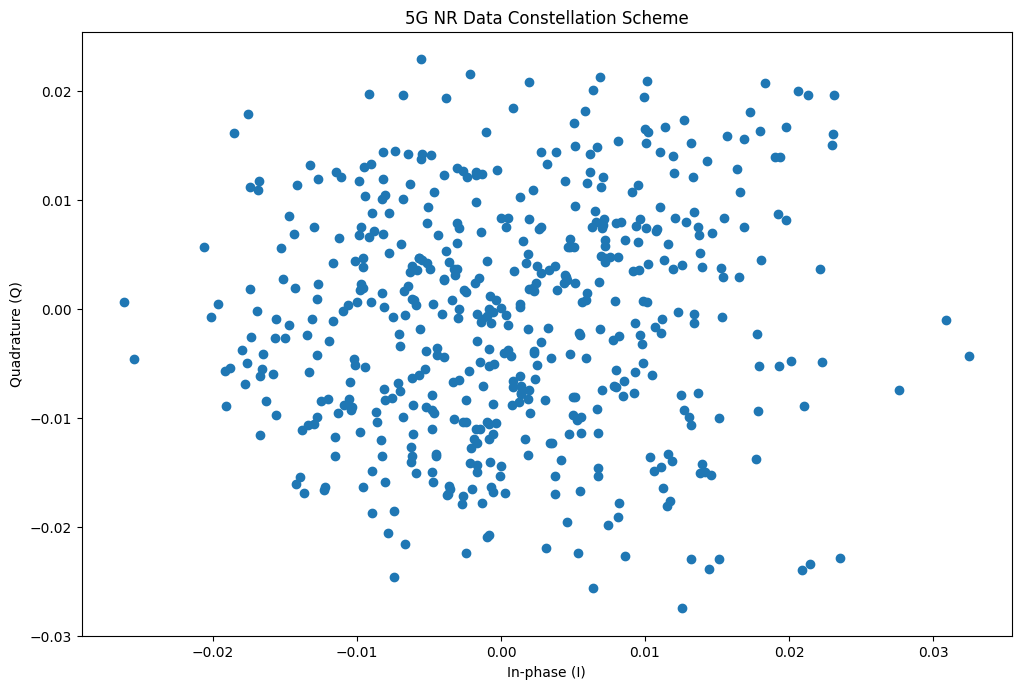

In [ ]:
plt.scatter(nr5g_df.apply(np.real).iloc[begin:end], nr5g_df.apply(np.imag).iloc[begin:end])
plt.title('5G NR Data Constellation Scheme')
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.show()

## 3. Pre-Processing

In [ ]:
wifi_complex_data = wifi_df.to_numpy()

n, p = wifi_complex_data.shape
n_leftout = n % IQ_PAIR
n_pair = n // IQ_PAIR

if n_leftout == 0:
    wifi_complex_data = wifi_complex_data.reshape(n_pair, IQ_PAIR)
else:
    wifi_complex_data = wifi_complex_data[:-n_leftout].reshape(n_pair, IQ_PAIR)

wifi_data = np.zeros((n_pair, IQ_PAIR, 2))
wifi_data[:, :, 0] = wifi_complex_data.real
wifi_data[:, :, 1] = wifi_complex_data.imag

print(wifi_data.shape)

(14410, 512, 2)


In [ ]:
lte_complex_data = lte_df.to_numpy()

n, p = lte_complex_data.shape
n_leftout = n % IQ_PAIR
n_pair = n // IQ_PAIR

if n_leftout == 0:
    lte_complex_data = lte_complex_data.reshape(n_pair, IQ_PAIR)
else:
    lte_complex_data = lte_complex_data[:-n_leftout].reshape(n_pair, IQ_PAIR)

lte_data = np.zeros((n_pair, IQ_PAIR, 2))
lte_data[:, :, 0] = lte_complex_data.real
lte_data[:, :, 1] = lte_complex_data.imag

print(lte_data.shape)

(13972, 512, 2)


In [ ]:
nr5g_complex_data = nr5g_df.to_numpy()

n, p = nr5g_complex_data.shape
n_leftout = n % IQ_PAIR
n_pair = n // IQ_PAIR

if n_leftout == 0:
    nr5g_complex_data = nr5g_complex_data.reshape(n_pair, IQ_PAIR)
else:
    nr5g_complex_data = nr5g_complex_data[:-n_leftout].reshape(n_pair, IQ_PAIR)

nr5g_data = np.zeros((n_pair, IQ_PAIR, 2))
nr5g_data[:, :, 0] = nr5g_complex_data.real
nr5g_data[:, :, 1] = nr5g_complex_data.imag

print(nr5g_data.shape)

(14250, 512, 2)


In [ ]:
wifi_label = np.full((wifi_data.shape[0]), CLASSES.index("wifi"))
lte_label = np.full((lte_data.shape[0]), CLASSES.index("lte"))
nr5g_label = np.full((nr5g_data.shape[0]), CLASSES.index("nr5g"))

data = np.concatenate((wifi_data, lte_data, nr5g_data))
label = np.concatenate((wifi_label, lte_label, nr5g_label))

train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=501)
train_data.shape, test_data.shape, train_label.shape, test_label.shape

((34105, 512, 2), (8527, 512, 2), (34105,), (8527,))

## 4. Model

In [ ]:
class lstmClassifier(nn.Module):
    def __init__(self, hidden_size=16, num_layers=1):
        super().__init__()

        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(INPUT_SIZE, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0)
        self.fc = nn.Linear(hidden_size, NUM_CLASSES)

    def forward(self, x):
        lstm_out, (ht, ct) = self.lstm(x)
        x = ht[-1]
        x = F.selu(self.fc(x))
        return x

## 5. Training

In [ ]:
def chunks(data, label, batch_size):
    for i in range(0, data.shape[0], batch_size):
        yield data[i:i + batch_size], label[i:i + batch_size]

def train(model, criterion, optimizer, dataloader, batch_size=64, learning_rate=1e-3, epochs=25, verbose=True):

    train_data, train_label, test_data, test_label = dataloader
    train_history, test_history = [], []

    for e in range(epochs):
        for batch_data, batch_label in chunks(train_data, train_label, batch_size):
            inputs = torch.from_numpy(batch_data).float().to(device)
            labels = torch.from_numpy(batch_label).to(device)

            optimizer.zero_grad()
            predictions = model(inputs).to(device)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            batch_number = 0
            train_loss = 0
            for batch_data, batch_label in chunks(train_data, train_label, 10000):
                batch_train_inputs = torch.from_numpy(batch_data).float().to(device)
                batch_train_labels = torch.from_numpy(batch_label).to(device)
                batch_train_predictions = model(batch_train_inputs).to(device)
                batch_train_loss = criterion(batch_train_predictions, batch_train_labels)
                train_loss += batch_train_loss.item()
                batch_number += 1
            train_loss /= batch_number
            train_history.append(train_loss)

            test_inputs = torch.from_numpy(test_data).float().to(device)
            test_labels = torch.from_numpy(test_label).to(device)
            test_predictions = model(test_inputs).to(device)
            test_loss = criterion(test_predictions, test_labels)
            test_history.append(test_loss.item())

            if verbose:
                print(f"Epoch {e} - Train Loss: {train_loss}, Test Loss: {test_loss.item()}")
        
    return model.eval(), train_history, test_history

In [ ]:
batch_size = 128
learning_rate = 1e-4
epochs = 100
hidden_size = 32
num_layers = 1

model = lstmClassifier(hidden_size, num_layers).to(device)
print(summary(model, input_size=(batch_size, IQ_PAIR, INPUT_SIZE)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

dataloader = (train_data, train_label, test_data, test_label)
model, train_history, test_history = train(model, criterion, optimizer, dataloader, batch_size, learning_rate, epochs)

Layer (type:depth-idx)                   Output Shape              Param #
lstmClassifier                           --                        --
├─LSTM: 1-1                              [128, 512, 32]            4,608
├─Linear: 1-2                            [128, 3]                  99
Total params: 4,707
Trainable params: 4,707
Non-trainable params: 0
Total mult-adds (M): 302.00
Input size (MB): 0.52
Forward/backward pass size (MB): 16.78
Params size (MB): 0.02
Estimated Total Size (MB): 17.32
Epoch 0 - Train Loss: 1.0964629650115967, Test Loss: 1.096435785293579
Epoch 1 - Train Loss: 1.0895152688026428, Test Loss: 1.0896577835083008
Epoch 2 - Train Loss: 0.8350164741277695, Test Loss: 0.8391370177268982
Epoch 3 - Train Loss: 0.8308367431163788, Test Loss: 0.8312926292419434
Epoch 4 - Train Loss: 0.8031449168920517, Test Loss: 0.8040522933006287
Epoch 5 - Train Loss: 0.724808543920517, Test Loss: 0.7186801433563232
Epoch 6 - Train Loss: 0.6552694141864777, Test Loss: 0.65538525581359

## 6. Analyzing

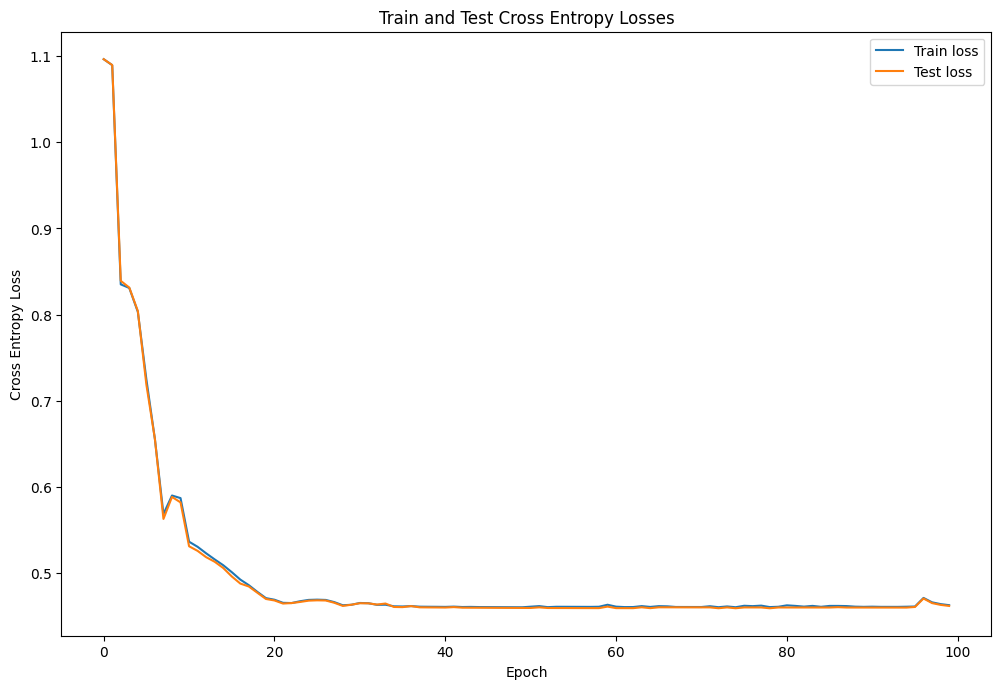

In [ ]:
plt.plot(train_history, label='Train loss')
plt.plot(test_history, label='Test loss')
plt.title('Train and Test Cross Entropy Losses')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

Classification Accuracy: 0.6790195848481295


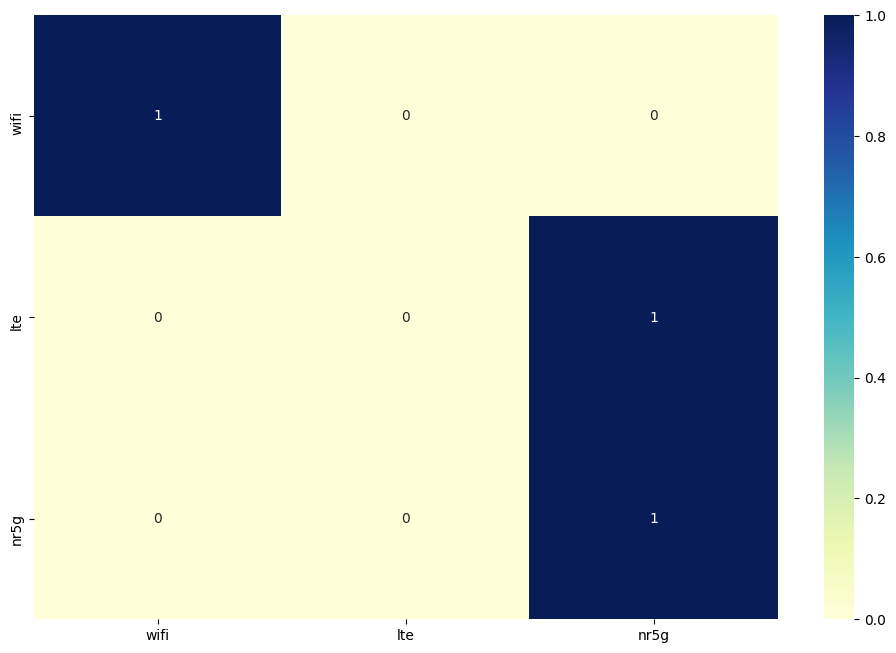

In [ ]:
with torch.no_grad():
    test_inputs = torch.from_numpy(test_data).float().to(device)
    test_labels = torch.from_numpy(test_label).to(device)
    test_predictions = model(test_inputs).to(device)
    test_loss = criterion(test_predictions, test_labels)

preds = test_predictions.cpu().detach().numpy().argmax(axis=1)
accuracy = np.mean(preds == test_label)
print(f"Classification Accuracy: {accuracy}")
confusion = confusion_matrix(test_label, preds, normalize='true')
heatmap = sns.heatmap(confusion, annot=True, xticklabels=CLASSES, yticklabels=CLASSES, cmap="YlGnBu")